## Assignment 7: Apply SVM to Amazon reviews data set [M]

Given Dataset consists of reviews of fine foods from amazon. Reviews describe (1)product and user information, (2)ratings, and (3) a plain text review.Here, SVM  algorithm is applied on amazon reviews datasets to predict whether a review is positive or negative.

Procedure to execute the above task is as follows:

* **Step1: Data Pre-processing is applied on given amazon reviews data-set.And Take sample of data from dataset because of computational limitations**


* **Step2: Time based splitting on train and test datasets.**


* **Step3: Apply  Feature generation techniques(Bow,tfidf,avg w2v,tfidfw2v)** 
  
  
* **Step4: Apply SVM  algorithm using each technique.**


* **Step5: To find C(1/alpha) and gamma(=1/sigma) using gridsearch cross-validation and random cross-validation**



         

## Objective:

* To classify given reviews (positive (Rating of 4 or 5) & negative (rating of 1 or 2)) using SVM algorithm.







In [1]:
# All necessary module
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
#import  sys
import re
import math
import sqlite3
import pandas as pd
import numpy as np
import pickle
# modules for text processing
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import TruncatedSVD

import pytablewriter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

#import scikitplot.metrics as skplt
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer



# train-split data,accuracy-score,cross-validation modules

from sklearn.neighbors import KNeighborsClassifier



from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

from sklearn.svm import SVC
from sklearn import linear_model
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV
from tqdm import tqdm
import os


In [2]:
import zipfile
archive = zipfile.ZipFile('/floyd/input/pri/Reviews.zip', 'r')
csvfile = archive.open('Reviews.csv')

In [3]:
# Reading CSV file and printing first five rows 
amz = pd.read_csv(csvfile ) # reviews.csv is  dataset file
print(amz.head())

   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1 

In [4]:
# dimensions of dataset and columns name
print(amz.shape) 
#print(amz1.shape)
print(amz.columns)

(568454, 10)
Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')


The amazon reviews datafile contains 568454 rows of entry and 10 columns.For given objective, processing of data is necessary."Score" and "text" columns is processed for required result.

##### Given reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating. If score is equal to 3,it is considered as neutral score.

In [5]:
# Processing
#Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.

def score_part(x):
    if x < 3:
        return 'negative'
    return 'positive'

actualScore = amz['Score']
#print(actualScore)
New_score = actualScore.map(score_part)
#print(New_score)
amz['Score']=New_score

# If score is equal to 3,it is considered as neutral score.


In [6]:
print(amz.shape)
amz.head(5)


(568454, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


#### Data Pre-processing on raw data:

Every datasets contains some unwanted data.Raw data is preprocessed by removing duplication.


In [7]:
#Processing of ProductId
#Sorting data according to ProductId in ascending order
sorted_data=amz.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
#sorted_data.head() # printing sorted data
# To check the duplications in raw data
dupli=sorted_data[sorted_data.duplicated(["UserId","ProfileName","Time","Text"])]
print(dupli.head(5))
# Remove Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(amz['Id'].size*1.0)*100
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

            Id   ProductId          UserId  \
171222  171223  7310172001   AJD41FBJD9010   
171153  171154  7310172001   AJD41FBJD9010   
171151  171152  7310172001   AJD41FBJD9010   
217443  217444  7310172101  A22FICU3LCG2J1   
217444  217445  7310172101  A1LQV0PSM04DWI   

                                         ProfileName  HelpfulnessNumerator  \
171222  N. Ferguson "Two, Daisy, Hannah, and Kitten"                     1   
171153  N. Ferguson "Two, Daisy, Hannah, and Kitten"                     0   
171151  N. Ferguson "Two, Daisy, Hannah, and Kitten"                     0   
217443                                      C. Knapp                     1   
217444                                 B. Feuerstein                     1   

        HelpfulnessDenominator     Score        Time  \
171222                       1  positive  1233360000   
171153                       0  positive  1233360000   
171151                       0  positive  1233360000   
217443                       1

positive    336824
negative     57107
Name: Score, dtype: int64

List of total counts Postive score and Negative score ==> [336824, 57107]


Text(0.5,1,'Total counts of Postive score and Negative score ')

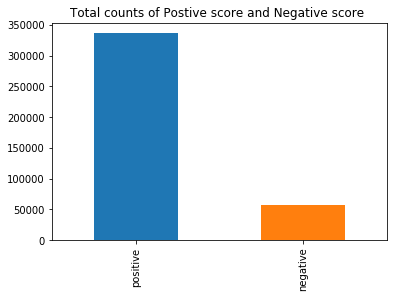

In [8]:
a=final['Score'].value_counts().tolist()
print('List of total counts Postive score and Negative score ==>',a)
final['Score'].value_counts().plot(kind='bar')
plt.title('Total counts of Postive score and Negative score ')


#### observations
* The positive reviews is greater than negative reviews.It makes data imbalanced.
* From the bar plot ,it is seen that sampled datasets of review is imbalnced.


# Text Preprocessing:

In [9]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
 
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>$< /><')
    #cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned


cleaning html tags like" <.*?>" and punctuations like " r'[?|!|\'|"|#]',r''" from senetences

In [11]:
#final = final.sample(frac=0.004,random_state=1)
#print(final.shape)

In [12]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase.

'''Pre processing of text data:It is cleaning and flitering text'''
i=0
str1=' '
global final_string
final_string=[]
all_positive_words=[] 
all_negative_words=[] 
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")

    final_string.append(str1)
    i+=1
#print('all_positive_words =',len(all_positive_words))
#print('all_negative_words =',len(all_negative_words))

# Finding most frequently occuring Positive and Negative words 

freq_positive=nltk.FreqDist(all_positive_words)

freq_negative=nltk.FreqDist(all_negative_words)

#print("\nMost Common Positive Words : ",freq_positive.most_common(20))

#print("\nMost Common Negative Words : ",freq_negative.most_common(20))




##### Dumping and loading  Pre processing of text data in pickle file 

In [13]:
pickle_path_final_string='final_string.pkl'
final_string_file=open(pickle_path_final_string,'wb')
pickle.dump(final_string,final_string_file)
final_string_file.close()

In [11]:
pickle_path_final_string='final_string.pkl'
final_string_unpkl=open(pickle_path_final_string,'rb')
final_string=pickle.load(final_string_unpkl)

In [12]:

final['CleanedText']=final_string
#adding a column of CleanedText which displays the data after pre-processing of the review 
Pre_Process_Data = final[['CleanedText','Score','Time']] 

X_Text=Pre_Process_Data ['CleanedText']

Y_Score =Pre_Process_Data ['Score'] # positive or negative score
print('\nPre_Process_Text_Data  X_Text=',X_Text.shape)
print('\nPre_Process_Score_Data Y_Score=',Y_Score.shape)



Pre_Process_Text_Data  X_Text= (393931,)

Pre_Process_Score_Data Y_Score= (393931,)


In [13]:
# postive and negtive reviews from original datasets of amazon
pos_final = Pre_Process_Data[Pre_Process_Data .Score == 'positive']# postive reviews
pos_final = pos_final.sample(frac=0.3)
print(pos_final.Score.value_counts())

neg_final = Pre_Process_Data [Pre_Process_Data .Score == 'negative'] # negative reviews
print(neg_final.Score.value_counts())

positive    101047
Name: Score, dtype: int64
negative    57107
Name: Score, dtype: int64


In [14]:
final_pos_neg = pd.concat([pos_final,neg_final],axis=0)
print(len(final_pos_neg))
print(type(final_pos_neg))


158154
<class 'pandas.core.frame.DataFrame'>


In [15]:
print(final_pos_neg.columns)

Index(['CleanedText', 'Score', 'Time'], dtype='object')


### Splitting Training and Testing dataset based on Time

In [16]:
# splitting training and testing dataset (Time based splitting)

X1 = final_pos_neg[['CleanedText','Time']].sort_values('Time',axis=0).drop('Time',axis=1)
#40k data sample
X=X1[:40000]

print(X.shape)
Y1 = final_pos_neg[['Score','Time']].sort_values('Time',axis=0).drop('Time',axis=1)
#40k data sample
Y=Y1[:40000]
print(Y.shape)
## 70 % of data

X_train_data ,X_test_data,Y_train_data,Y_test_data  = train_test_split(X,
                                                      Y.values.ravel(),                                                                       
                                                    test_size=0.3,
                                                    shuffle=False)



print('X_train_data ',X_train_data.shape)

print('X_test_data ',X_test_data.shape )

print('Y_train_data ',Y_train_data .shape)

print('Y_test_data ',Y_test_data .shape)



(40000, 1)
(40000, 1)
X_train_data  (28000, 1)
X_test_data  (12000, 1)
Y_train_data  (28000,)
Y_test_data  (12000,)


In [17]:

Y_new = Y['Score'].map(lambda x: 1 if x == 'positive' else 0).values.ravel()
# Y train and Test for sparse datasets

y_train_new,y_test_new = train_test_split(Y_new,test_size=0.3,shuffle=False)
print('y_train_new ',y_train_new.shape)

print('y_test_new ',y_test_new .shape)


y_train_new  (28000,)
y_test_new  (12000,)


#  Optimal Lambda for SVM

In [18]:
models_performence = {
    'Model':[],
    'Vectorizer': [],
    'SearchCV':[],
    'Scoring Metrics': [],
    'Train_model_score': [],
    'Test_model_score': [],   
    'Best lambda':[],
}

columns = ["Model","Vectorizer","SearchCV", "Scoring Metrics","Train_model_score","Test_model_score","Best lambda"]
pd.DataFrame(models_performence, columns=columns)
     
   

,Model,Vectorizer,SearchCV,Scoring Metrics,Train_model_score,Test_model_score,Best lambda


In [19]:
 # Time seris splitting Cross-Validation
tscv = TimeSeriesSplit(n_splits=3)

In [20]:
#  optimal_svm is function to calculate the hyperparametr c for SGD_clf

def optimal_svm(X_train,y_train,X_test, y_test,vectorization):    
    C = [1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]
    
    
    #  hyperparameter options
    hp1 =dict(alpha= C)
     
    # Scoring options
    d=[ 'f1','roc_auc']    
    for i in tqdm(range(len(d))):
        models_performence['Model'].append('SGDClassifier')
        models_performence['Vectorizer'].append(vectorization)
        models_performence['SearchCV'].append('GridSearchCV')
        p = d[i]
        SGD_clf = linear_model.SGDClassifier(loss='hinge',
                                             n_iter=100,
                                             learning_rate='optimal',
                                             class_weight='balanced',
                                             n_jobs= -1)
        models_performence['Scoring Metrics'].append(p)
        model1 = GridSearchCV(SGD_clf,
                              hp1,
                              scoring = p,
                              cv=tscv,n_jobs= -1)
        best_model1=model1.fit(X_train, y_train)        
        Test_model_score=best_model1.score(X_test, y_test)
        Train_model_score=best_model1.score(X_train, y_train)
      
        models_performence['Train_model_score'].append(Train_model_score.mean())
        models_performence['Test_model_score'].append(Test_model_score.mean())        
      
        optimal_l1=best_model1.best_estimator_.get_params()['alpha']        
        models_performence['Best lambda'].append(optimal_l1)
        
       

In [21]:
#  error_plot is function to calculate performance of datasets with different value of 
#  the hyperparametr c .

def error_plot(classifier,p,X_train,y_train,X_test, y_test):    
    C = [1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]   
    train_error=[]
    test_error=[]
    
    for i in tqdm(range(len(C))):
        hp1 =dict(alpha=[C[i]])
      
        model1 = GridSearchCV(classifier, hp1,
                              scoring =p ,
                              cv=tscv,n_jobs= -1)
        best_model1=model1.fit(X_train, y_train)        
        Test_score=model1.score(X_test, y_test)
        test_error.append(1-Test_score)
        
        Train_score=model1.score(X_train, y_train)
        train_error.append(1-Train_score)
        


    fig = plt.figure( facecolor='y', edgecolor='k')
    plt.semilogx(C,train_error,'m*',linestyle='dashed', label='Train')
    plt.semilogx(C,test_error,'r*', linestyle='dashed',label='Test')
    plt.legend(loc='lower left')
    plt.grid()

    plt.xlabel('Regularization parameter(C)')
    plt.ylabel('Performance')
    plt.show()



##### Pandas dataframe to markdown Table format

In [22]:
# result_display  is function to convert dataframe into table format in Markdown
def result_display(df):
    writer = pytablewriter.MarkdownTableWriter()
    writer.header_list = list(df.columns.values)
    writer.value_matrix = df.values.tolist()
    writer.write_table()

# Methods to convert text into vector

Methods:
* Bag of Words
* Avg word2vec
* Tf-idf
* tf-idf weighted Word2Vec

Using above four method is used to convert text to numeric vector.

# 1. Bag of Words (BoW)

##### BOW for Training Data

In [23]:
count_vect = CountVectorizer() #in scikit-learn
vect_Data = count_vect.fit_transform(X_train_data.values.ravel())
print(vect_Data .shape)

(28000, 20759)


In [24]:
# truncated SVD for dimesionality reduction for 100 dimensions
svd = TruncatedSVD(n_components=100,n_iter=7)

Data=svd.fit_transform(vect_Data )
print("TruncatedSVD :",Data.shape)
    

TruncatedSVD : (28000, 100)


In [25]:
# StandardScaler
final_data= StandardScaler(with_mean=False).fit_transform(Data )

print(final_data.shape)
#Normalize Data


warnings.filterwarnings("ignore") 

(28000, 100)


#### Dumping & Loading Pickle file for training data ( BOW )


In [26]:
#Pickle file for training data

pickle_path_BOW_train='X_train_data_BOW.pkl'
X_train_data_BOW=open(pickle_path_BOW_train,'wb')
pickle.dump(final_data ,X_train_data_BOW)
X_train_data_BOW.close()


In [27]:
pickle_path_BOW_train='X_train_data_BOW.pkl'
unpickle_path1=open(pickle_path_BOW_train,'rb')
final_data=pickle.load(unpickle_path1)

In [28]:
from sklearn.externals import joblib
joblib.dump(final_data, 'final_data.joblib') 

['final_data.joblib']

In [29]:
final_data = joblib.load('final_data.joblib') 

##### BOW for Testing Data

In [30]:
#vector of test data
vect_Data1= count_vect.transform(X_test_data.values.ravel())
print(vect_Data1.shape)



final_data_test=svd.transform(vect_Data1)
print("TruncatedSVD :",final_data_test.shape)

(12000, 20759)
TruncatedSVD : (12000, 100)


#### Dumping & Loading Pickle file for testing data ( BOW) 

In [31]:
pickle_path_BOW_test='X_test_data_BOW.pkl'
X_test_data_BOW=open(pickle_path_BOW_test,'wb')
pickle.dump(final_data_test ,X_test_data_BOW)
X_test_data_BOW.close()

In [32]:
pickle_path_BOW_test='X_test_data_BOW.pkl'
unpickle_path2=open(pickle_path_BOW_test,'rb')
final_data_test=pickle.load(unpickle_path2)

 Featured data of Bag of words is Standardization (mean=0 and std.dev=1).

In [33]:
Train_data=y_train_new

In [34]:
# To get optimal lambda using BOW


#print(Y_test_data)

#print(Train_data)
vectorization='BOW'
optimal_lambda = optimal_svm(final_data ,Train_data,
                             final_data_test,y_test_new,
                             vectorization)

100%|██████████| 2/2 [00:44<00:00, 22.01s/it]


In [35]:
columns = ["Model","Vectorizer","SearchCV",
           "Scoring Metrics","Train_model_score","Test_model_score","Best lambda"]
df=pd.DataFrame(models_performence, columns=columns)
result_display(df)    
   

|    Model    |Vectorizer|  SearchCV  |Scoring Metrics|Train_model_score|Test_model_score|Best lambda|
|-------------|----------|------------|---------------|----------------:|---------------:|----------:|
|SGDClassifier|BOW       |GridSearchCV|f1             |         0.000201|           0.000|       5.00|
|SGDClassifier|BOW       |GridSearchCV|roc_auc        |         0.837396|           0.820|       0.05|



### Observation:

|    Model    |Vectorizer|  SearchCV  |Scoring Metrics|Train_model_score|Test_model_score|Best lambda|
|-------------|----------|------------|---------------|----------------:|---------------:|----------:|
|SGDClassifier|BOW       |GridSearchCV|f1             |         0.000201|           0.000|       5.00|
|SGDClassifier|BOW       |GridSearchCV|roc_auc        |         0.837396|           0.820|       0.05|      0.05|


In [36]:
#### Observations:
df=pd.DataFrame(models_performence, columns=columns)
zx=df[df['Scoring Metrics'] == 'f1']['Best lambda'].ravel()
lambdax=zx[0]
print(lambdax)
#Mscoring=


5.0


In [37]:
#Best lambda 
hp1=dict(alpha=[lambdax])
SGD_clf = linear_model.SGDClassifier(loss='hinge',
                                     n_iter=100,
                                     learning_rate='optimal',
                                     class_weight='balanced',
                                     n_jobs= -1)
          
svm =GridSearchCV(SGD_clf,
                  hp1, 
                  scoring ='f1',
                  cv=tscv,
                  n_jobs= -1)
svm.fit(final_data ,Train_data)

prediction1 =svm.predict(final_data_test)


In [38]:
#Training accuracy and training error
training_score=svm.score(final_data,Train_data)
print('training accuracy=',training_score)
training_error=1-training_score
print('training error is =',training_error)

training accuracy= 0.8330283719267251
training error is = 0.16697162807327492


In [39]:
# Testing Accuracy and testing error for LogisticRegression model

Testing_score=round(accuracy_score(y_test_new ,prediction1),5)
print("Accuracy for SGD_clf model with Bag of words is = ",Testing_score)
Testing_error=1-Testing_score
print("Testing error for SGD_clf model with Bag of words is = ",Testing_error)

Accuracy for SGD_clf model with Bag of words is =  0.67675
Testing error for SGD_clf model with Bag of words is =  0.32325000000000004


In [40]:
F1_score = round(f1_score(y_test_new ,prediction1,average='macro'),5)*100
recall = round(recall_score(y_test_new,prediction1,average='macro'),5)*100
precision = round(precision_score(y_test_new ,prediction1,average='macro'),5)*100

In [41]:
print(classification_report(y_test_new,prediction1))

             precision    recall  f1-score   support

          0       0.80      0.01      0.02      3906
          1       0.68      1.00      0.81      8094

avg / total       0.72      0.68      0.55     12000



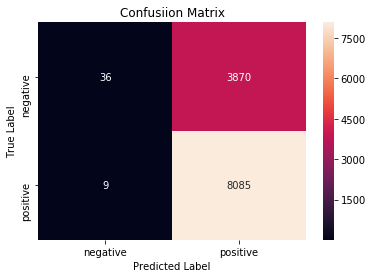

In [42]:
cm = confusion_matrix(y_test_new ,prediction1)
label = ['negative', 'positive']
df_conf = pd.DataFrame(cm, index = label, columns = label)
sns.heatmap(df_conf, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

100%|██████████| 15/15 [00:38<00:00,  2.59s/it]


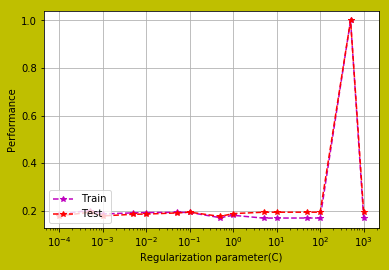

In [43]:
classifier=SGD_clf
p='f1'
error_plot(classifier,p,final_data ,Train_data
           ,final_data_test,y_test_new)

In [44]:

models_performence1 = {
    'Model':['SGD_clf'],   
    'Vectorizer': [vectorization],
    
    'Optimal lambda': [lambdax],
    'Training error':[training_error],
    'Test error':[Testing_error],
    'Accuracy':[Testing_score],
    'F1':[F1_score],
    'recall':[recall],
    'precision':[precision]
    
  
}

In [45]:
columns = ["Model","Vectorizer","Optimal lambda", 
           "Training error",  "Test error",
            "Accuracy","F1","recall","precision",
          ]
df1=pd.DataFrame(models_performence1, columns=columns)
result_display(df1)

| Model |Vectorizer|Optimal lambda|Training error|Test error|Accuracy| F1  |recall|precision|
|-------|----------|-------------:|-------------:|---------:|-------:|----:|-----:|--------:|
|SGD_clf|BOW       |             5|        0.1670|    0.3233|  0.6767|41.24| 50.40|    73.81|



### Observation

| Model |Vectorizer|Optimal lambda|Training error|Test error|Accuracy| F1  |recall|precision|
|-------|----------|-------------:|-------------:|---------:|-------:|----:|-----:|--------:|
|SGD_clf|BOW       |             5|        0.1670|    0.3233|  0.6767|41.24| 50.40|    73.81|


* Optimal lambda using SGD_clf for BOW is 5 using 'f1' scoring metrics
* from Performance graph of traing and testing data with different lambda value is almost overlapping each other.
* TPR & FPR is too high as seen in confusion matrix.

In [46]:

zx=df[df['Scoring Metrics'] == 'roc_auc']['Best lambda'].ravel()
lambdax=zx[0]
print(lambdax)

0.05


In [47]:
#Best lambda 
hp1=dict(alpha=[lambdax])
SGD_clf = linear_model.SGDClassifier(loss='hinge',n_iter=1000,
                                     learning_rate='optimal',
                                     class_weight='balanced',
                                     n_jobs= -1)
          
svm1 =GridSearchCV(SGD_clf, hp1,
                   scoring ='roc_auc',
                   cv=tscv,n_jobs= -1)
svm1.fit(final_data ,Train_data)

prediction2 =svm1.predict(final_data_test)

In [48]:
#Training accuracy and training error
training_score=svm1.score(final_data,Train_data)
print('training accuracy=',training_score)
training_error=1-training_score
print('training error is =',training_error)

training accuracy= 0.8374079776093861
training error is = 0.16259202239061388


In [49]:
# Testing Accuracy and testing error 
Testing_score=round(accuracy_score(y_test_new ,prediction2),5)
print("Accuracy for SGD_clf model with Bag of words is = ",Testing_score)
Testing_error=1-Testing_score
print("Testing error for SGD_clf model with Bag of words is = ",Testing_error)

Accuracy for SGD_clf model with Bag of words is =  0.7565
Testing error for SGD_clf model with Bag of words is =  0.24350000000000005


In [50]:
F1_score = round(f1_score(y_test_new ,prediction2,average='macro'),5)*100
recall = round(recall_score(y_test_new,prediction2,average='macro'),5)*100
precision = round(precision_score(y_test_new,prediction2,average='macro'),5)*100

In [51]:
print(classification_report( y_test_new,prediction2))

             precision    recall  f1-score   support

          0       0.60      0.74      0.66      3906
          1       0.86      0.77      0.81      8094

avg / total       0.78      0.76      0.76     12000



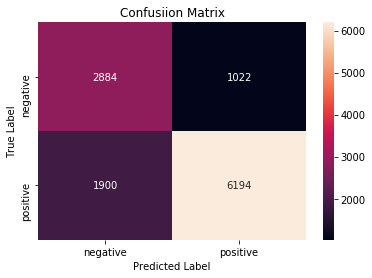

In [52]:
cm = confusion_matrix(y_test_new,prediction2)
label = ['negative', 'positive']
df_conf = pd.DataFrame(cm, index = label, columns = label)
sns.heatmap(df_conf, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

100%|██████████| 15/15 [05:24<00:00, 21.61s/it]


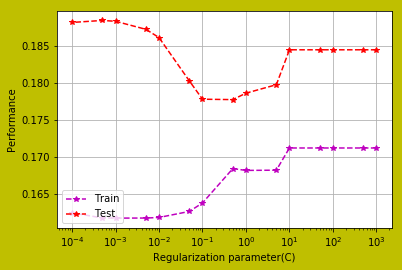

In [53]:
classifier=SGD_clf
p='roc_auc'
error_plot(classifier,p,final_data ,Train_data,
           final_data_test,y_test_new)

In [54]:
models_performence1['Model'].append('SGDClassifier')
models_performence1['Vectorizer'].append(vectorization)

models_performence1[ 'Optimal lambda'].append(lambdax)
models_performence1['Training error'].append(training_error)
models_performence1[ 'Test error'].append(Testing_error)
models_performence1[ 'Accuracy'].append(Testing_score)
models_performence1[ 'F1'].append(F1_score)
models_performence1['recall'].append(recall)
models_performence1[ 'precision'].append(precision)

In [55]:
columns = ["Model","Vectorizer","Optimal lambda",
           "Training error",  "Test error",
            "Accuracy","F1","recall","precision",
          ]
df2=pd.DataFrame(models_performence1, columns=columns)
result_display(df2)

|    Model    |Vectorizer|Optimal lambda|Training error|Test error|Accuracy| F1  |recall|precision|
|-------------|----------|-------------:|-------------:|---------:|-------:|----:|-----:|--------:|
|SGD_clf      |BOW       |          5.00|        0.1670|    0.3233|  0.6767|41.24| 50.40|    73.81|
|SGDClassifier|BOW       |          0.05|        0.1626|    0.2435|  0.7565|73.65| 75.18|    73.06|



### Observation 

|    Model    |Vectorizer|Optimal lambda|Training error|Test error|Accuracy| F1  |recall|precision|
|-------------|----------|-------------:|-------------:|---------:|-------:|----:|-----:|--------:|
|SGD_clf      |BOW       |          5.00|        0.1670|    0.3233|  0.6767|41.24| 50.40|    73.81|
|SGDClassifier|BOW       |          0.05|        0.1626|    0.2435|  0.7565|73.65| 75.18|    73.06|


* Optimal lambda using sgd_clf for BOW with scoring metrics "roc_auc" is 0.05. which is giving best result as compared  sgd_clf for BOW with scoring metrics "f1".
* 'f1' score is 73.65%
* from Performance graph of traing and testing data with different lambda value is seen in graph. The training and testing performance differs at initial period and then it remains same.

* TPR & TNR is high as compared FPR & FNR. It means model performs very well ans model is sensible.

* From above observation  it can be concluded that
  ##### SGD_clf for BOW using scoring metrics "roc_auc" works best as comapred to scoring metrics "f1".

# 2. Avg word2vec
Firstly, word2vec model is designed for amazon reviews using gensim module.

In [56]:
import gensim
list_sent=[]
for text in tqdm(X_train_data.values.ravel()): 
    filter_text=[]
    for i in text.split():
        if(i.isalpha()):
            filter_text.append(i.lower().decode("utf-8"))
        else:
            continue 
    list_sent.append(filter_text)
print(len(list_sent))


    

100%|██████████| 28000/28000 [00:00<00:00, 31150.03it/s]

28000


##### word2vec Model using Training Datasets

In [57]:

w2v_model=gensim.models.Word2Vec(list_sent,min_count=5,size=100, workers=4) 
#this model is used in avg word2vec  .  


In [58]:
words = list(w2v_model.wv.vocab)
print(len(words))

7245


In [59]:
pickle_path_w2v_model='w2v_model.pkl'
w2v_model_path=open(pickle_path_w2v_model,'wb')
pickle.dump(w2v_model,w2v_model_path)
w2v_model_path.close()

In [60]:
pickle_path_w2v_model='w2v_model.pkl'
unpickle_w2v_model=open(pickle_path_w2v_model,'rb')
w2v_model=pickle.load(unpickle_w2v_model)

#### Avg Word2Vec 

In [61]:
#  For Training

sent_vectors = []
for sent in  tqdm(list_sent): # for each review/sentence
    sent_vec = np.zeros(100) 
    cnt_words =0 # num of words with a valid vector in the sentence/review
    for word in sent: 
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)


print(len(sent_vectors))

#print(sent_vectors[0:4])




100%|██████████| 28000/28000 [00:05<00:00, 5537.60it/s]

28000


In [62]:
# Converting Nan value to zero in sent vectors.
Sent_Nan = np.where(np.isnan(sent_vectors), 0, sent_vectors)

In [63]:
# converting sent list to nd array
Sent_final_vector = np.asarray(Sent_Nan )
print(type(Sent_final_vector))

<class 'numpy.ndarray'>


In [64]:
#  ForTesting
# Words in test reviews
list_sent_test=[]
for text in tqdm(X_test_data.values.ravel()): 
    filter_text=[]
    for i in text.split():
        if(i.isalpha()):
            filter_text.append(i.lower().decode("utf-8"))
        else:
            continue 
    list_sent_test.append(filter_text)
#print(len(list_sent_test))

sent_vectors1 = []
for sent in tqdm(list_sent_test): # for each review/sentence
    sent_vec = np.zeros(100) 
    cnt_words =0 # num of words with a valid vector in the sentence/review
    for word in sent: 
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors1.append(sent_vec)


print(len(sent_vectors1))

#print(sent_vectors1)
# Converting Nan value to zero in sent vectors.
Sent_Nan1 = np.where(np.isnan(sent_vectors1), 0, sent_vectors1)

# converting sent list to nd array
Sent_final_vector1 = np.asarray(Sent_Nan1)
print(type(Sent_final_vector1))

100%|██████████| 12000/12000 [00:02<00:00, 5277.81it/s]

12000
<class 'numpy.ndarray'>


#### Dumping & Loading Pickle file for  Avg word2vec

In [65]:
pickle_path_AW2V_train='X_data_AW2V_train.pkl'
X_data_AW2V_train=open(pickle_path_AW2V_train,'wb')
pickle.dump(Sent_final_vector,X_data_AW2V_train)
X_data_AW2V_train.close()

pickle_path_AW2V_test='X_data_AW2V_test.pkl'
X_data_AW2V_test=open(pickle_path_AW2V_test,'wb')
pickle.dump(Sent_final_vector1,X_data_AW2V_test)
X_data_AW2V_test.close()


In [66]:
pickle_path_AW2V_train='X_data_AW2V_train.pkl'
unpickle_path3_train=open(pickle_path_AW2V_train,'rb')
Sent_final_vector=pickle.load(unpickle_path3_train)

pickle_path_AW2V_test='X_data_AW2V_test.pkl'
unpickle_path3_test=open(pickle_path_AW2V_test,'rb')
Sent_final_vecto1=pickle.load(unpickle_path3_test)

##### Standardscaler  training avg word2vec

In [67]:
final_w2v_count_Train= StandardScaler(with_mean=False).fit_transform(Sent_final_vector)
# For Train
print(final_w2v_count_Train.shape)

(28000, 100)


In [68]:
final_w2v_count_Test=Sent_final_vector1

In [69]:
print(final_w2v_count_Test.shape)

(12000, 100)


##### for Training datasets ,avg word2vec 
                 final_w2v_count_Train,                 
              
   
##### for testing datasets ,avg word2vec 
                 final_w2v_count_Test, 
                

In [70]:
vectorization='Avg Word2Vec'
optimal_lambda = optimal_svm(final_w2v_count_Train ,
                             Train_data,
                             final_w2v_count_Test,
                             y_test_new,vectorization )

100%|██████████| 2/2 [00:42<00:00, 21.07s/it]


In [71]:
columns = ["Model","Vectorizer","SearchCV",
           "Scoring Metrics","Train_model_score",
           "Test_model_score","Best lambda"]
df3=pd.DataFrame(models_performence, columns=columns)
result_display(df3)     
   

|    Model    | Vectorizer |  SearchCV  |Scoring Metrics|Train_model_score|Test_model_score|Best lambda|
|-------------|------------|------------|---------------|----------------:|---------------:|----------:|
|SGDClassifier|BOW         |GridSearchCV|f1             |         0.000201|           0.000|      5.000|
|SGDClassifier|BOW         |GridSearchCV|roc_auc        |         0.837396|           0.820|      0.050|
|SGDClassifier|Avg Word2Vec|GridSearchCV|f1             |         0.338159|           0.000|     10.000|
|SGDClassifier|Avg Word2Vec|GridSearchCV|roc_auc        |         0.881242|           0.880|      0.005|



|    Model    | Vectorizer |  SearchCV  |Scoring Metrics|Train_model_score|Test_model_score|Best lambda|
|-------------|------------|------------|---------------|----------------:|---------------:|----------:|
|SGDClassifier|BOW         |GridSearchCV|f1             |         0.000201|           0.000|      5.000|
|SGDClassifier|BOW         |GridSearchCV|roc_auc        |         0.837396|           0.820|      0.050|
|SGDClassifier|Avg Word2Vec|GridSearchCV|f1             |         0.338159|           0.000|     10.000|
|SGDClassifier|Avg Word2Vec|GridSearchCV|roc_auc        |         0.881242|           0.880|      0.005|

In [72]:
df=pd.DataFrame(models_performence, columns=columns)
df=df[df['Vectorizer'] == 'Avg Word2Vec']
zx=df[df['Scoring Metrics'] == 'f1']['Best lambda'].ravel()
lambdax=zx[0]
print(lambdax)

10.0


In [73]:
#Best lambda 
hp1=dict(alpha=[lambdax])
SGD_clf = linear_model.SGDClassifier(loss='hinge',n_iter=1000,
                                     learning_rate='optimal',
                                     class_weight='balanced',
                                     n_jobs= -1)
          
svm3 =GridSearchCV(SGD_clf,hp1, scoring ='f1', cv=tscv,n_jobs= -1)
svm3.fit(final_w2v_count_Train ,Train_data)

prediction3 =svm3.predict( final_w2v_count_Test)


In [74]:
#Training accuracy and training error
training_score=svm3.score(final_w2v_count_Train ,Train_data)
print('training accuracy=',training_score)
training_error=1-training_score
print('training error is =',training_error)

training accuracy= 0.8605808546928666
training error is = 0.1394191453071334


In [75]:
# Testing Accuracy and testing error for  model
Testing_score=round(accuracy_score(y_test_new ,prediction3),5)
print("Accuracy for  model with Avg word2vec is = ",Testing_score)
Testing_error=1-Testing_score
print("Testing error for  model with Avg word2ve is = ",Testing_error)

Accuracy for  model with Avg word2vec is =  0.67483
Testing error for  model with Avg word2ve is =  0.32516999999999996


In [76]:
F1_score = round(f1_score(y_test_new ,prediction3,average='macro'),5)*100
recall = round(recall_score(y_test_new,prediction3,average='macro'),5)*100
precision = round(precision_score(y_test_new ,prediction3,average='macro'),5)*100

In [77]:
print(classification_report( y_test_new,prediction3))

             precision    recall  f1-score   support

          0       0.83      0.00      0.00      3906
          1       0.67      1.00      0.81      8094

avg / total       0.73      0.67      0.54     12000



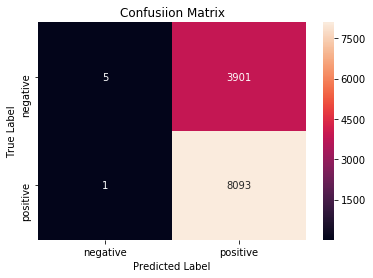

In [78]:
cm = confusion_matrix(y_test_new,prediction3)
label = ['negative', 'positive']
df_conf = pd.DataFrame(cm, index = label, columns = label)
sns.heatmap(df_conf, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

100%|██████████| 15/15 [05:09<00:00, 20.61s/it]


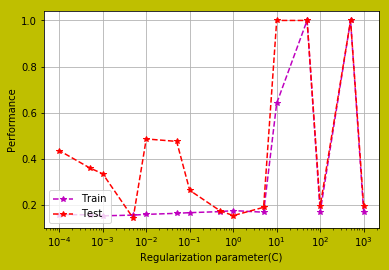

In [79]:
classifier=SGD_clf
p='f1'
error_plot(classifier,p,
           final_w2v_count_Train ,
           Train_data, 
           final_w2v_count_Test,
           y_test_new)

In [80]:
models_performence1['Model'].append('SGD_clf')
models_performence1['Vectorizer'].append(vectorization)

models_performence1[ 'Optimal lambda'].append(lambdax)
models_performence1['Training error'].append(training_error)
models_performence1[ 'Test error'].append(Testing_error)
models_performence1[ 'Accuracy'].append(Testing_score)
models_performence1[ 'F1'].append(F1_score)
models_performence1['recall'].append(recall)
models_performence1[ 'precision'].append(precision)


In [81]:
columns = ["Model","Vectorizer","Optimal lambda",
           "Training error",  "Test error",
            "Accuracy","F1","recall","precision",
          ]
df4=pd.DataFrame(models_performence1, columns=columns)
result_display(df4)

|    Model    | Vectorizer |Optimal lambda|Training error|Test error|Accuracy| F1  |recall|precision|
|-------------|------------|-------------:|-------------:|---------:|-------:|----:|-----:|--------:|
|SGD_clf      |BOW         |          5.00|        0.1670|    0.3233|  0.6767|41.24| 50.40|    73.81|
|SGDClassifier|BOW         |          0.05|        0.1626|    0.2435|  0.7565|73.65| 75.18|    73.06|
|SGD_clf      |Avg Word2Vec|         10.00|        0.1394|    0.3252|  0.6748|40.42| 50.06|    75.40|



### Observation

|    Model    | Vectorizer |Optimal lambda|Training error|Test error|Accuracy| F1  |recall|precision|
|-------------|------------|-------------:|-------------:|---------:|-------:|----:|-----:|--------:|
|SGD_clf      |BOW         |          5.00|        0.1670|    0.3233|  0.6767|41.24| 50.40|    73.81|
|SGDClassifier|BOW         |          0.05|        0.1626|    0.2435|  0.7565|73.65| 75.18|    73.06|
|SGD_clf      |Avg Word2Vec|         10.00|        0.1394|    0.3252|  0.6748|40.42| 50.06|    75.40|


* Using Avg Word2vec & scoring metrics f1, Optimal lambda for model is 10.
* TPR & FPR is too high and TNR & FNR is too low.
* Performance of traing and testing with different lamda values are shown in figure.
* Precision istoo high and F1 is too low.

In [82]:

zx=df[df['Scoring Metrics'] == 'roc_auc']['Best lambda'].ravel()
lambdax=zx[0]
print(lambdax)

0.005


In [83]:
#Best lambda 
hp1=dict(alpha=[lambdax])
SGD_clf = linear_model.SGDClassifier(loss='hinge',
                                     n_iter=1000,
                                     learning_rate='optimal',
                                     class_weight='balanced',
                                      n_jobs= -1)
          
svm4 =GridSearchCV(SGD_clf, hp1, 
                   scoring ='roc_auc', 
                   cv=tscv,n_jobs= -1)
svm4.fit(final_w2v_count_Train ,Train_data)

prediction4 = svm4.predict(final_w2v_count_Test)

In [84]:
#Training accuracy and training error
training_score=svm4.score(final_w2v_count_Train ,Train_data)
print('training accuracy=',training_score)
training_error=1-training_score
print('training error is =',training_error)

training accuracy= 0.8814606970701757
training error is = 0.11853930292982429


In [85]:
# Testing Accuracy and testing error 

Testing_score=round(accuracy_score(y_test_new ,prediction4),5)
print("Accuracy for SGD_clf model with Avg word2ve is = ",Testing_score)
Testing_error=1-Testing_score
print("Testing error for SGD_clf model with Avg word2ve is = ",Testing_error)

Accuracy for SGD_clf model with Avg word2ve is =  0.478
Testing error for SGD_clf model with Avg word2ve is =  0.522


In [86]:
F1_score = round(f1_score(y_test_new ,prediction4,average='macro'),5)*100
recall = round(recall_score(y_test_new,prediction4,average='macro'),5)*100
precision = round(precision_score(y_test_new ,prediction4,average='macro'),5)*100

In [87]:
print(classification_report( y_test_new,prediction4))

             precision    recall  f1-score   support

          0       0.38      0.99      0.55      3906
          1       0.99      0.23      0.37      8094

avg / total       0.79      0.48      0.43     12000



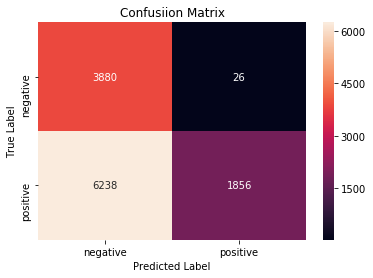

In [88]:
cm = confusion_matrix(y_test_new,prediction4)
label = ['negative', 'positive']
df_conf = pd.DataFrame(cm, index = label, columns = label)
sns.heatmap(df_conf, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

100%|██████████| 15/15 [05:17<00:00, 21.20s/it]


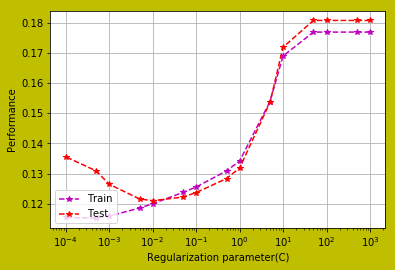

In [89]:
classifier=SGD_clf
p='roc_auc'
error_plot(classifier,p,
           final_w2v_count_Train ,Train_data,
           final_w2v_count_Test,y_test_new)

In [90]:
models_performence1['Model'].append('SGD_clf')
models_performence1['Vectorizer'].append(vectorization)

models_performence1[ 'Optimal lambda'].append(lambdax)
models_performence1['Training error'].append(training_error)
models_performence1[ 'Test error'].append(Testing_error)
models_performence1[ 'Accuracy'].append(Testing_score)
models_performence1[ 'F1'].append(F1_score)
models_performence1['recall'].append(recall)
models_performence1[ 'precision'].append(precision)

In [91]:
columns = ["Model","Vectorizer","Optimal lambda", "Training error",  "Test error",
            "Accuracy","F1","recall","precision",
          ]
df5=pd.DataFrame(models_performence1, columns=columns)
result_display(df5)

|    Model    | Vectorizer |Optimal lambda|Training error|Test error|Accuracy| F1  |recall|precision|
|-------------|------------|-------------:|-------------:|---------:|-------:|----:|-----:|--------:|
|SGD_clf      |BOW         |         5.000|        0.1670|    0.3233|  0.6767|41.24| 50.40|    73.81|
|SGDClassifier|BOW         |         0.050|        0.1626|    0.2435|  0.7565|73.65| 75.18|    73.06|
|SGD_clf      |Avg Word2Vec|        10.000|        0.1394|    0.3252|  0.6748|40.42| 50.06|    75.40|
|SGD_clf      |Avg Word2Vec|         0.005|        0.1185|    0.5220|  0.4780|46.27| 61.13|    68.48|



### Observation

|    Model    | Vectorizer |Optimal lambda|Training error|Test error|Accuracy| F1  |recall|precision|
|-------------|------------|-------------:|-------------:|---------:|-------:|----:|-----:|--------:|
|SGD_clf      |BOW         |         5.000|        0.1670|    0.3233|  0.6767|41.24| 50.40|    73.81|
|SGDClassifier|BOW         |         0.050|        0.1626|    0.2435|  0.7565|73.65| 75.18|    73.06|
|SGD_clf      |Avg Word2Vec|        10.000|        0.1394|    0.3252|  0.6748|40.42| 50.06|    75.40|
|SGD_clf      |Avg Word2Vec|         0.005|        0.1185|    0.5220|  0.4780|46.27| 61.13|    68.48|

* Optimal lambda using SGD_clf with scoring metrics "roc_auc" is 0.005.
* TNR & FNR is too high as compared to TPR & FPR.
* Error is high for highest value of lambda as seen in performance metrics.


##### TF-IDF for Training data

In [92]:

tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf11 = tf_idf_vect.fit_transform(X_train_data.values.ravel())
final_tf_idf11.get_shape()
tfidf_feat = tf_idf_vect.get_feature_names() 

In [93]:
final_tf_idf=svd.fit_transform(final_tf_idf11 )
print("TruncatedSVD :",final_tf_idf.shape)


TruncatedSVD : (28000, 100)


#### Dumping & Loading Pickle file for training data (TF-IDF)

In [94]:
pickle_path_tfidf_train='X_train_data_tfidf.pkl'
X_train_data_tfidf=open(pickle_path_tfidf_train,'wb')
pickle.dump(final_tf_idf ,X_train_data_tfidf)
X_train_data_tfidf.close()

In [95]:
pickle_path_tfidf_train='X_train_data_tfidf.pkl'
unpickle_path5=open(pickle_path_tfidf_train,'rb')
final_tf_idf=pickle.load(unpickle_path5)

In [96]:
#StandardScaleing and normalizing training Tf-IDF
final_tfidf_np= StandardScaler(with_mean=False).fit_transform(final_tf_idf)

print("Train Data: ",final_tfidf_np.shape)


warnings.filterwarnings("ignore")    

Train Data:  (28000, 100)


##### tf-idf For Testing datasets 

In [97]:
final_tf_idf_test1_svd = tf_idf_vect.transform(X_test_data.values.ravel())
final_tf_idf_test1_svd.get_shape()

(12000, 493550)

In [98]:

final_tf_idf_test1=svd.transform(final_tf_idf_test1_svd)
print("TruncatedSVD :",final_tf_idf_test1.shape)
#Normalize Data
#X_sparse_tsvd = svd.fit(vect_Data1).transform(X_sparse)

TruncatedSVD : (12000, 100)


#### Dumping & Loading Pickle file for testing data(TF-IDF)

In [99]:

pickle_path_tfidf_test='X_test_data_tfidf.pkl'
X_test_data_tfidf=open(pickle_path_tfidf_test,'wb')
pickle.dump(final_tf_idf_test1 ,X_test_data_tfidf)
X_test_data_tfidf.close()

In [100]:
pickle_path_tfidf_test='X_test_data_tfidf.pkl'
unpickle_path6=open(pickle_path_tfidf_test,'rb')
final_tfidf_np_test=pickle.load(unpickle_path6)

In [101]:
vectorization='TF-IDF'
optimal_lambda = optimal_svm(final_tfidf_np ,
                             Train_data,final_tfidf_np_test,
                             y_test_new,vectorization )


100%|██████████| 2/2 [00:42<00:00, 21.48s/it]


In [102]:
columns = ["Model","Vectorizer","SearchCV",
           "Scoring Metrics","Train_model_score",
           "Test_model_score","Best lambda"]
df6=pd.DataFrame(models_performence, columns=columns)
result_display(df6)    
   

|    Model    | Vectorizer |  SearchCV  |Scoring Metrics|Train_model_score|Test_model_score|Best lambda|
|-------------|------------|------------|---------------|----------------:|---------------:|----------:|
|SGDClassifier|BOW         |GridSearchCV|f1             |         0.000201|           0.000|      5.000|
|SGDClassifier|BOW         |GridSearchCV|roc_auc        |         0.837396|           0.820|      0.050|
|SGDClassifier|Avg Word2Vec|GridSearchCV|f1             |         0.338159|           0.000|     10.000|
|SGDClassifier|Avg Word2Vec|GridSearchCV|roc_auc        |         0.881242|           0.880|      0.005|
|SGDClassifier|TF-IDF      |GridSearchCV|f1             |         0.767114|           0.000|      1.000|
|SGDClassifier|TF-IDF      |GridSearchCV|roc_auc        |         0.892100|           0.886|      0.005|



|    Model    | Vectorizer |  SearchCV  |Scoring Metrics|Train_model_score|Test_model_score|Best lambda|
|-------------|------------|------------|---------------|----------------:|---------------:|----------:|
|SGDClassifier|BOW         |GridSearchCV|f1             |         0.000201|           0.000|      5.000|
|SGDClassifier|BOW         |GridSearchCV|roc_auc        |         0.837396|           0.820|      0.050|
|SGDClassifier|Avg Word2Vec|GridSearchCV|f1             |         0.338159|           0.000|     10.000|
|SGDClassifier|Avg Word2Vec|GridSearchCV|roc_auc        |         0.881242|           0.880|      0.005|
|SGDClassifier|TF-IDF      |GridSearchCV|f1             |         0.767114|           0.000|      1.000|
|SGDClassifier|TF-IDF      |GridSearchCV|roc_auc        |         0.892100|           0.886|      0.005|

In [103]:
df=pd.DataFrame(models_performence, columns=columns)
df=df[df['Vectorizer'] == 'TF-IDF']
zx=df[df['Scoring Metrics'] == 'f1']['Best lambda'].ravel()
lambdax=zx[0]
print(lambdax)

1.0


In [104]:
#Best lambda 
hp1=dict(alpha=[lambdax])
SGD_clf = linear_model.SGDClassifier(loss='hinge',
                                     n_iter=1000,
                                     learning_rate='optimal',
                                     class_weight='balanced',
                                     
                                    n_jobs= -1)
          
svm5 =GridSearchCV(SGD_clf,hp1,
                   scoring ='f1',
                   cv=tscv,n_jobs= -1)
svm5.fit(final_tfidf_np ,Train_data)

prediction5 =svm5.predict(final_tfidf_np_test)


In [105]:
#Training accuracy and training error
training_score=svm5.score(final_tfidf_np ,Train_data)
print('training accuracy=',training_score)
training_error=1-training_score
print('training error is =',training_error)

training accuracy= 0.8710525643971305
training error is = 0.12894743560286948


In [106]:
# Testing Accuracy and testing error 

Testing_score=round(accuracy_score(y_test_new ,prediction5),5)
print("Accuracy for SGD_clf model with TF-IDF is = ",Testing_score)
Testing_error=1-Testing_score
print("Testing error for SGD_clf model with TF-IDF is = ",Testing_error)

Accuracy for SGD_clf model with TF-IDF is =  0.6745
Testing error for SGD_clf model with TF-IDF is =  0.3255


In [107]:
F1_score = round(f1_score(y_test_new ,prediction5,average='macro'),5)*100
recall = round(recall_score(y_test_new,prediction5,average='macro'),5)*100
precision = round(precision_score(y_test_new ,prediction5,average='macro'),5)*100

In [108]:
print(classification_report( y_test_new,prediction5))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00      3906
          1       0.67      1.00      0.81      8094

avg / total       0.45      0.67      0.54     12000



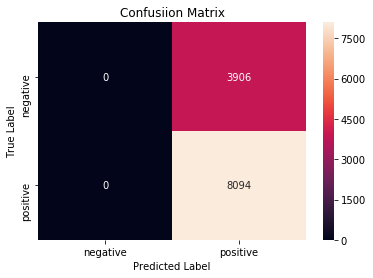

In [109]:
cm = confusion_matrix(y_test_new ,prediction5)
label = ['negative', 'positive']
df_conf = pd.DataFrame(cm, index = label, columns = label)
sns.heatmap(df_conf, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

100%|██████████| 15/15 [05:19<00:00, 21.28s/it]


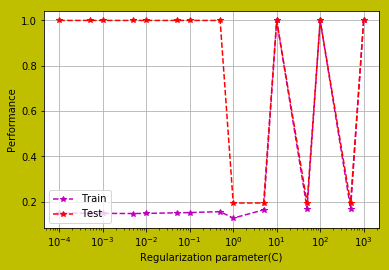

In [110]:
classifier=SGD_clf
p='f1'
error_plot(classifier,p,final_tfidf_np ,
           Train_data,
           final_tfidf_np_test,y_test_new)

In [111]:
models_performence1['Model'].append('SGD_clf')
models_performence1['Vectorizer'].append(vectorization)

models_performence1[ 'Optimal lambda'].append(lambdax)
models_performence1['Training error'].append(training_error)
models_performence1[ 'Test error'].append(Testing_error)
models_performence1[ 'Accuracy'].append(Testing_score)
models_performence1[ 'F1'].append(F1_score)
models_performence1['recall'].append(recall)
models_performence1[ 'precision'].append(precision)

In [112]:
columns = ["Model","Vectorizer","Optimal lambda",
           "Training error",  "Test error",
            "Accuracy","F1","recall","precision",
          ]
df7=pd.DataFrame(models_performence1, columns=columns)
result_display(df7)

|    Model    | Vectorizer |Optimal lambda|Training error|Test error|Accuracy| F1  |recall|precision|
|-------------|------------|-------------:|-------------:|---------:|-------:|----:|-----:|--------:|
|SGD_clf      |BOW         |          5.00|        0.1670|    0.3233|  0.6767|41.24| 50.40|    73.81|
|SGDClassifier|BOW         |          0.05|        0.1626|    0.2435|  0.7565|73.65| 75.18|    73.06|
|SGD_clf      |Avg Word2Vec|         10.00|        0.1394|    0.3252|  0.6748|40.42| 50.06|    75.40|
|SGD_clf      |Avg Word2Vec|          0.00|        0.1185|    0.5220|  0.4780|46.27| 61.13|    68.48|
|SGD_clf      |TF-IDF      |          1.00|        0.1289|    0.3255|  0.6745|40.28| 50.00|    33.72|



### Observation

|    Model    | Vectorizer |Optimal lambda|Training error|Test error|Accuracy| F1  |recall|precision|
|-------------|------------|-------------:|-------------:|---------:|-------:|----:|-----:|--------:|
|SGD_clf      |BOW         |          5.00|        0.1670|    0.3233|  0.6767|41.24| 50.40|    73.81|
|SGDClassifier|BOW         |          0.05|        0.1626|    0.2435|  0.7565|73.65| 75.18|    73.06|
|SGD_clf      |Avg Word2Vec|         10.00|        0.1394|    0.3252|  0.6748|40.42| 50.06|    75.40|
|SGD_clf      |Avg Word2Vec|          0.00|        0.1185|    0.5220|  0.4780|46.27| 61.13|    68.48|
|SGD_clf      |TF-IDF      |          1.00|        0.1289|    0.3255|  0.6745|40.28| 50.00|    33.72|

* Optimal lambda is 1 for TF_IDF with scoring metrics"f1".
* Performnce of datasets with different lambda value is shown in graph.Traing graph and testing graph for different lambda values are almost overlapping each other when lambda value is high



In [113]:
zx=df[df['Scoring Metrics'] == 'roc_auc']['Best lambda'].ravel()
lambdax=zx[0]
print(lambdax)

0.005


In [114]:
#Best lambda 
hp1=dict(alpha=[lambdax])
SGD_clf = linear_model.SGDClassifier(loss='hinge',
                                     n_iter=1000,
                                     learning_rate='optimal',
                                     class_weight='balanced',
                                     n_jobs= -1)
          
svm6 =GridSearchCV(SGD_clf, hp1, 
                   scoring ='roc_auc', 
                   cv=tscv,n_jobs= -1)
svm6.fit(final_tfidf_np ,Train_data)

prediction6 = svm6.predict(final_tfidf_np_test)

In [115]:
#Training accuracy and training error
training_score=svm6.score(final_tfidf_np,Train_data)
print('training accuracy=',training_score)
training_error=1-training_score
print('training error is =',training_error)

training accuracy= 0.89207620082491
training error is = 0.10792379917508998


In [116]:
# Testing Accuracy and testing error 

Testing_score=round(accuracy_score(y_test_new ,prediction6),5)
print("Accuracy for SGD_clf model with TF-IDF is = ",Testing_score)
Testing_error=1-Testing_score
print("Testing error for SGD_clf model with TF-IDF is = ",Testing_error)

Accuracy for SGD_clf model with TF-IDF is =  0.3255
Testing error for SGD_clf model with TF-IDF is =  0.6745


In [117]:
F1_score = round(f1_score(y_test_new ,prediction6,average='macro'),5)*100
recall = round(recall_score(y_test_new,prediction6,average='macro'),5)*100
precision = round(precision_score(y_test_new ,prediction6,average='macro'),5)*100

In [118]:
print(classification_report(y_test_new,prediction6))

             precision    recall  f1-score   support

          0       0.33      1.00      0.49      3906
          1       0.00      0.00      0.00      8094

avg / total       0.11      0.33      0.16     12000



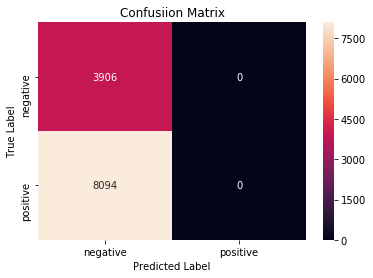

In [119]:
cm = confusion_matrix(y_test_new ,prediction6)
label = ['negative', 'positive']
df_conf = pd.DataFrame(cm, index = label, columns = label)
sns.heatmap(df_conf, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

100%|██████████| 15/15 [05:13<00:00, 20.91s/it]


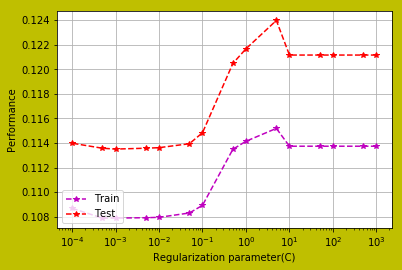

In [120]:
classifier=SGD_clf
p='roc_auc'
error_plot(classifier,p,
           final_tfidf_np ,
           Train_data,
           final_tfidf_np_test,
           y_test_new)

In [121]:
models_performence1['Model'].append('SGD_clf')
models_performence1['Vectorizer'].append(vectorization)

models_performence1[ 'Optimal lambda'].append(lambdax)
models_performence1['Training error'].append(training_error)
models_performence1[ 'Test error'].append(Testing_error)
models_performence1[ 'Accuracy'].append(Testing_score)
models_performence1[ 'F1'].append(F1_score)
models_performence1['recall'].append(recall)
models_performence1[ 'precision'].append(precision)


In [122]:
columns = ["Model","Vectorizer","Optimal lambda",
           "Training error",  "Test error",
            "Accuracy","F1","recall","precision",
          ]
df8=pd.DataFrame(models_performence1, columns=columns)
result_display(df8)

|    Model    | Vectorizer |Optimal lambda|Training error|Test error|Accuracy| F1  |recall|precision|
|-------------|------------|-------------:|-------------:|---------:|-------:|----:|-----:|--------:|
|SGD_clf      |BOW         |         5.000|        0.1670|    0.3233|  0.6767|41.24| 50.40|    73.81|
|SGDClassifier|BOW         |         0.050|        0.1626|    0.2435|  0.7565|73.65| 75.18|    73.06|
|SGD_clf      |Avg Word2Vec|        10.000|        0.1394|    0.3252|  0.6748|40.42| 50.06|    75.40|
|SGD_clf      |Avg Word2Vec|         0.005|        0.1185|    0.5220|  0.4780|46.27| 61.13|    68.48|
|SGD_clf      |TF-IDF      |         1.000|        0.1289|    0.3255|  0.6745|40.28| 50.00|    33.72|
|SGD_clf      |TF-IDF      |         0.005|        0.1079|    0.6745|  0.3255|24.56| 50.00|    16.28|



### Observation

|    Model    | Vectorizer |Optimal lambda|Training error|Test error|Accuracy| F1  |recall|precision|
|-------------|------------|-------------:|-------------:|---------:|-------:|----:|-----:|--------:|
|SGD_clf      |BOW         |         5.000|        0.1670|    0.3233|  0.6767|41.24| 50.40|    73.81|
|SGDClassifier|BOW         |         0.050|        0.1626|    0.2435|  0.7565|73.65| 75.18|    73.06|
|SGD_clf      |Avg Word2Vec|        10.000|        0.1394|    0.3252|  0.6748|40.42| 50.06|    75.40|
|SGD_clf      |Avg Word2Vec|         0.005|        0.1185|    0.5220|  0.4780|46.27| 61.13|    68.48|
|SGD_clf      |TF-IDF      |         1.000|        0.1289|    0.3255|  0.6745|40.28| 50.00|    33.72|
|SGD_clf      |TF-IDF      |         0.005|        0.1079|    0.6745|  0.3255|24.56| 50.00|    16.28|

* SGD_clf using TF-IDF for scoring metrics "roc_auc" is 0.005.
* Performance graph is as shown above.
* TNR & FNR is high in case of SGD_clf using TF-IDF for scoring metrics "roc_auc"  whereas TPR & FPR is high in case of  SGD_clf using TF-IDF for scoring metrics "f1".


#  4.TF-IDF weighted Word2Vec

In [123]:
w2v_words = list(w2v_model.wv.vocab)

In [124]:
tfidf_feat = tf_idf_vect.get_feature_names() 
dictionary = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))

In [125]:
# TF-IDF weighted Word2Vec
tfidf_feat =tf_idf_vect.get_feature_names() # tfidf words/col-names

tfidf_sent_vectors = []; 
row=0;
for sent in tqdm(X_train_data.values.ravel()): 
    sent_vec = np.zeros(100) 
    weight_sum =0;
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
#             
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors .append(sent_vec)
    row += 1

100%|██████████| 28000/28000 [15:02<00:00, 31.01it/s]


In [126]:
print(len(tfidf_sent_vectors))

28000


In [127]:
print(tfidf_sent_vectors[2])
tfidf_sent_vectors_train  = np.where(np.isnan(tfidf_sent_vectors ), 0, tfidf_sent_vectors )
print(tfidf_sent_vectors_train[2])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [128]:
tfidf_sent_vectors_train  = np.asarray(tfidf_sent_vectors_train )
print(type(tfidf_sent_vectors))

<class 'list'>


#### Dumping & Loading Pickle file for trainText data (TF-IDF weighted word2vec)

In [129]:
pickle_path_tfidf_weighted='X_data_tfidf_weighted.pkl'
X_data_tfidf_weighted=open(pickle_path_tfidf_weighted,'wb')
pickle.dump(tfidf_sent_vectors_train  ,X_data_tfidf_weighted)
X_data_tfidf_weighted.close()

In [130]:
pickle_path_tfidf_weighted='X_data_tfidf_weighted.pkl'
unpickle_path7=open(pickle_path_tfidf_weighted,'rb')
tfidf_sent_vectors_train =pickle.load(unpickle_path7)

In [131]:
final_tfidf_w2v_np_train= StandardScaler(with_mean=False).fit_transform(tfidf_sent_vectors_train)


##### For test Tf-idf weighted word2vec

In [132]:
# TF-IDF weighted Word2Vec
tfidf_feat =tf_idf_vect.get_feature_names() # tfidf words/col-names

tfidf_sent_vectors1 = []; 
row=0;
for sent in tqdm(X_test_data.values.ravel()): 
    sent_vec = np.zeros(100) 
    weight_sum =0;
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
#             
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors1 .append(sent_vec)
    row += 1

100%|██████████| 12000/12000 [06:40<00:00, 29.96it/s]


In [133]:
print(len(tfidf_sent_vectors1))
print(tfidf_sent_vectors1[2])
tfidf_sent_vectors_test  = np.where(np.isnan(tfidf_sent_vectors1 ),
                                     0, tfidf_sent_vectors1 )
print(tfidf_sent_vectors_test[2])
final_tfidf_w2v_np_test = np.asarray(tfidf_sent_vectors_test )
print(type(tfidf_sent_vectors1))

12000
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
<class 'list'>


#### Dumping & Loading Pickle file for test Text data (TF-IDF weighted word2vec)

In [134]:
pickle_path_tfidf_weighted1='X_data_tfidf_weighted_test.pkl'
X_data_tfidf_weighted1=open(pickle_path_tfidf_weighted1,'wb')
pickle.dump(final_tfidf_w2v_np_test  ,X_data_tfidf_weighted1)
X_data_tfidf_weighted1.close()

In [135]:
pickle_path_tfidf_weighted1='X_data_tfidf_weighted_test.pkl'
unpickle_path71=open(pickle_path_tfidf_weighted1,'rb')
final_tfidf_w2v_np_test =pickle.load(unpickle_path71)

for Training Data:

            
            final_tfidf_w2v_np_train

For testing data:

            
            final_tfidf_w2v_np_test
    

### Optimal SVM for TF-IDF weighted Word2Vec

In [136]:
vectorization='TF-IDF weighted Word2Vec'
optimal_lambda = optimal_svm(final_tfidf_w2v_np_train,
                             Train_data,
                             final_tfidf_w2v_np_test,
                             y_test_new,vectorization )


100%|██████████| 2/2 [00:50<00:00, 25.10s/it]


In [137]:
columns = ["Model","Vectorizer","SearchCV",
           "Scoring Metrics","Train_model_score", 
           "Test_model_score","Best lambda"]
df9=pd.DataFrame(models_performence, columns=columns)
result_display(df9)

|    Model    |       Vectorizer       |  SearchCV  |Scoring Metrics|Train_model_score|Test_model_score|Best lambda|
|-------------|------------------------|------------|---------------|----------------:|---------------:|----------:|
|SGDClassifier|BOW                     |GridSearchCV|f1             |          0.00020|          0.0000|       5.00|
|SGDClassifier|BOW                     |GridSearchCV|roc_auc        |          0.83740|          0.8197|       0.05|
|SGDClassifier|Avg Word2Vec            |GridSearchCV|f1             |          0.33816|          0.0000|      10.00|
|SGDClassifier|Avg Word2Vec            |GridSearchCV|roc_auc        |          0.88124|          0.8796|       0.00|
|SGDClassifier|TF-IDF                  |GridSearchCV|f1             |          0.76711|          0.0000|       1.00|
|SGDClassifier|TF-IDF                  |GridSearchCV|roc_auc        |          0.89210|          0.8864|       0.00|
|SGDClassifier|TF-IDF weighted Word2Vec|GridSearchCV|f1         

|    Model    |       Vectorizer       |  SearchCV  |Scoring Metrics|Train_model_score|Test_model_score|Best lambda|
|-------------|------------------------|------------|---------------|----------------:|---------------:|----------:|
|SGDClassifier|BOW                     |GridSearchCV|f1             |          0.00020|          0.0000|       5.00|
|SGDClassifier|BOW                     |GridSearchCV|roc_auc        |          0.83740|          0.8197|       0.05|
|SGDClassifier|Avg Word2Vec            |GridSearchCV|f1             |          0.33816|          0.0000|      10.00|
|SGDClassifier|Avg Word2Vec            |GridSearchCV|roc_auc        |          0.88124|          0.8796|       0.00|
|SGDClassifier|TF-IDF                  |GridSearchCV|f1             |          0.76711|          0.0000|       1.00|
|SGDClassifier|TF-IDF                  |GridSearchCV|roc_auc        |          0.89210|          0.8864|       0.00|
|SGDClassifier|TF-IDF weighted Word2Vec|GridSearchCV|f1             |          0.83014|          0.8056|    1000.00|
|SGDClassifier|TF-IDF weighted Word2Vec|GridSearchCV|roc_auc        |          0.50000|          0.5000|    1000.00|

In [138]:
df=pd.DataFrame(models_performence, columns=columns)
df=df[df['Vectorizer'] == 'TF-IDF weighted Word2Vec']
zx=df[df['Scoring Metrics'] == 'f1']['Best lambda'].ravel()
lambdax=zx[0]
print(lambdax)

1000.0


In [139]:
#Best lambda 
hp1=dict(alpha=[lambdax])
SGD_clf = linear_model.SGDClassifier(loss='hinge',
                                     n_iter=1000,
                                     learning_rate='optimal',
                                     class_weight='balanced',
                                    n_jobs= -1)
          
svm7 =GridSearchCV(SGD_clf,hp1, 
                   scoring ='f1', 
                   cv=tscv,n_jobs= -1)
svm7.fit(final_tfidf_w2v_np_train,Train_data)

prediction7 =svm7.predict(final_tfidf_w2v_np_test)


In [140]:
#Training accuracy and training error
training_score=svm7.score(final_tfidf_w2v_np_train,Train_data)
print('training accuracy=',training_score)
training_error=1-training_score
print('training error is =',training_error)

training accuracy= 0.8301405920324219
training error is = 0.16985940796757815


In [141]:
# Testing Accuracy and testing error 

Testing_score=round(accuracy_score(y_test_new ,prediction7),5)
print("Accuracy for SGD_clf model with TF-IDF weighted Word2Vec is = ",Testing_score)
Testing_error=1-Testing_score
print("Testing error for SGD_clfmodel with TF-IDF weighted Word2Vec is = ",Testing_error)

Accuracy for SGD_clf model with TF-IDF weighted Word2Vec is =  0.6745
Testing error for SGD_clfmodel with TF-IDF weighted Word2Vec is =  0.3255


In [142]:
F1_score = round(f1_score(y_test_new ,prediction7,average='macro'),5)*100
recall = round(recall_score(y_test_new,prediction7,average='macro'),5)*100
precision = round(precision_score(y_test_new ,prediction7,average='macro'),5)*100

In [143]:
print(classification_report( y_test_new,prediction7))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00      3906
          1       0.67      1.00      0.81      8094

avg / total       0.45      0.67      0.54     12000



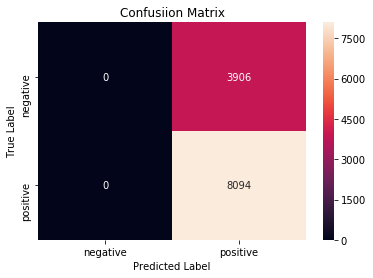

In [144]:
cm = confusion_matrix(y_test_new ,prediction7)
label = ['negative', 'positive']
df_conf = pd.DataFrame(cm, index = label, columns = label)
sns.heatmap(df_conf, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

100%|██████████| 15/15 [05:58<00:00, 23.88s/it]


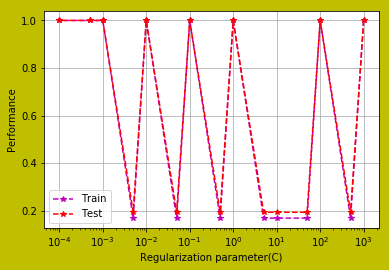

In [145]:
classifier=SGD_clf
p='f1'
error_plot(classifier,p,
           final_tfidf_w2v_np_train,
           Train_data,
           final_tfidf_w2v_np_test,y_test_new)

In [146]:
models_performence1['Model'].append('SGD_clf')
models_performence1['Vectorizer'].append(vectorization)

models_performence1[ 'Optimal lambda'].append(lambdax)
models_performence1['Training error'].append(training_error)
models_performence1[ 'Test error'].append(Testing_error)
models_performence1[ 'Accuracy'].append(Testing_score)
models_performence1[ 'F1'].append(F1_score)
models_performence1['recall'].append(recall)
models_performence1[ 'precision'].append(precision)

In [147]:
columns = ["Model","Vectorizer","Optimal lambda",
           "Training error",  "Test error",
            "Accuracy","F1","recall","precision",
          ]
df10=pd.DataFrame(models_performence1, columns=columns)
result_display(df10)

|    Model    |       Vectorizer       |Optimal lambda|Training error|Test error|Accuracy| F1  |recall|precision|
|-------------|------------------------|-------------:|-------------:|---------:|-------:|----:|-----:|--------:|
|SGD_clf      |BOW                     |         5.000|        0.1670|    0.3233|  0.6767|41.24| 50.40|    73.81|
|SGDClassifier|BOW                     |         0.050|        0.1626|    0.2435|  0.7565|73.65| 75.18|    73.06|
|SGD_clf      |Avg Word2Vec            |        10.000|        0.1394|    0.3252|  0.6748|40.42| 50.06|    75.40|
|SGD_clf      |Avg Word2Vec            |         0.005|        0.1185|    0.5220|  0.4780|46.27| 61.13|    68.48|
|SGD_clf      |TF-IDF                  |         1.000|        0.1289|    0.3255|  0.6745|40.28| 50.00|    33.72|
|SGD_clf      |TF-IDF                  |         0.005|        0.1079|    0.6745|  0.3255|24.56| 50.00|    16.28|
|SGD_clf      |TF-IDF weighted Word2Vec|      1000.000|        0.1699|    0.3255|  0.674

### Observations:

|    Model    |       Vectorizer       |Optimal lambda|Training error|Test error|Accuracy| F1  |recall|precision|
|-------------|------------------------|-------------:|-------------:|---------:|-------:|----:|-----:|--------:|
|SGD_clf      |BOW                     |         5.000|        0.1670|    0.3233|  0.6767|41.24| 50.40|    73.81|
|SGDClassifier|BOW                     |         0.050|        0.1626|    0.2435|  0.7565|73.65| 75.18|    73.06|
|SGD_clf      |Avg Word2Vec            |        10.000|        0.1394|    0.3252|  0.6748|40.42| 50.06|    75.40|
|SGD_clf      |Avg Word2Vec            |         0.005|        0.1185|    0.5220|  0.4780|46.27| 61.13|    68.48|
|SGD_clf      |TF-IDF                  |         1.000|        0.1289|    0.3255|  0.6745|40.28| 50.00|    33.72|
|SGD_clf      |TF-IDF                  |         0.005|        0.1079|    0.6745|  0.3255|24.56| 50.00|    16.28|
|SGD_clf      |TF-IDF weighted Word2Vec|      1000.000|        0.1699|    0.3255|  0.6745|40.28| 50.00|    33.72|

* lambda value for TF-IDF weighted Word2Vec	 usingscoring metrics "f1"is high (1000).
* TPR & FPR is high and performance graph looks like peak tooth wave.


In [148]:
zx=df[df['Scoring Metrics'] == 'roc_auc']['Best lambda'].ravel()
lambdax=zx[0]
print(lambdax)

1000.0


In [149]:
#Best lambda 
hp1=dict(alpha=[lambdax])
SGD_clf = linear_model.SGDClassifier(loss='hinge',
                                     n_iter=1000,
                                     learning_rate='optimal',
                                     class_weight='balanced',
                                     n_jobs= -1)
          
svm8 =GridSearchCV(SGD_clf, hp1,
                   scoring ='roc_auc',
                   cv=tscv,n_jobs= -1)
svm8.fit(final_tfidf_w2v_np_train,Train_data)

prediction8 = svm8.predict(final_tfidf_w2v_np_test)

In [150]:
#Training accuracy and training error
training_score=svm8.score(final_tfidf_w2v_np_train,Train_data)
print('training accuracy=',training_score)
training_error=1-training_score
print('training error is =',training_error)

training accuracy= 0.5
training error is = 0.5


In [151]:
# Testing Accuracy and testing error 

Testing_score=round(accuracy_score(y_test_new ,prediction8),5)
print("Accuracy for SGD_clf model with TF-IDF weighted Word2Vec is = ",Testing_score)
Testing_error=1-Testing_score
print("Testing error for SGD_clf model with TF-IDF weighted Word2Vec is = ",Testing_error)

Accuracy for SGD_clf model with TF-IDF weighted Word2Vec is =  0.6745
Testing error for SGD_clf model with TF-IDF weighted Word2Vec is =  0.3255


In [152]:
F1_score = round(f1_score(y_test_new,prediction8,average='macro'),5)*100
recall = round(recall_score(y_test_new,prediction8,average='macro'),5)*100
precision = round(precision_score(y_test_new ,prediction8,average='macro'),5)*100

In [153]:
print(classification_report( y_test_new,prediction8))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00      3906
          1       0.67      1.00      0.81      8094

avg / total       0.45      0.67      0.54     12000



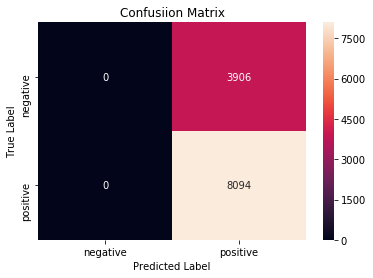

In [154]:
cm = confusion_matrix(y_test_new ,prediction8)
label = ['negative', 'positive']
df_conf = pd.DataFrame(cm, index = label, columns = label)
sns.heatmap(df_conf, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

100%|██████████| 15/15 [05:59<00:00, 23.97s/it]


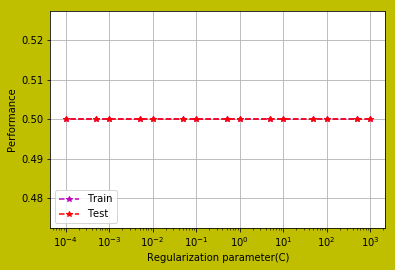

In [155]:
classifier=SGD_clf
p='roc_auc'
error_plot(classifier,p,
           final_tfidf_w2v_np_train,
           Train_data,final_tfidf_w2v_np_test,
           y_test_new)

In [156]:
models_performence1['Model'].append('SGD_clf')
models_performence1['Vectorizer'].append(vectorization)

models_performence1[ 'Optimal lambda'].append(lambdax)
models_performence1['Training error'].append(training_error)
models_performence1[ 'Test error'].append(Testing_error)
models_performence1[ 'Accuracy'].append(Testing_score)
models_performence1[ 'F1'].append(F1_score)
models_performence1['recall'].append(recall)
models_performence1[ 'precision'].append(precision)

In [157]:
columns = ["Model","Vectorizer","Optimal lambda", "Training error",  "Test error",
            "Accuracy","F1","recall","precision",
          ]
df11=pd.DataFrame(models_performence1, columns=columns)
result_display(df11)

|    Model    |       Vectorizer       |Optimal lambda|Training error|Test error|Accuracy| F1  |recall|precision|
|-------------|------------------------|-------------:|-------------:|---------:|-------:|----:|-----:|--------:|
|SGD_clf      |BOW                     |          5.00|        0.1670|    0.3233|  0.6767|41.24| 50.40|    73.81|
|SGDClassifier|BOW                     |          0.05|        0.1626|    0.2435|  0.7565|73.65| 75.18|    73.06|
|SGD_clf      |Avg Word2Vec            |         10.00|        0.1394|    0.3252|  0.6748|40.42| 50.06|    75.40|
|SGD_clf      |Avg Word2Vec            |          0.00|        0.1185|    0.5220|  0.4780|46.27| 61.13|    68.48|
|SGD_clf      |TF-IDF                  |          1.00|        0.1289|    0.3255|  0.6745|40.28| 50.00|    33.72|
|SGD_clf      |TF-IDF                  |          0.00|        0.1079|    0.6745|  0.3255|24.56| 50.00|    16.28|
|SGD_clf      |TF-IDF weighted Word2Vec|       1000.00|        0.1699|    0.3255|  0.674

### Observation

|    Model    |       Vectorizer       |Optimal lambda|Training error|Test error|Accuracy| F1  |recall|precision|
|-------------|------------------------|-------------:|-------------:|---------:|-------:|----:|-----:|--------:|
|SGD_clf      |BOW                     |          5.00|        0.1670|    0.3233|  0.6767|41.24| 50.40|    73.81|
|SGDClassifier|BOW                     |          0.05|        0.1626|    0.2435|  0.7565|73.65| 75.18|    73.06|
|SGD_clf      |Avg Word2Vec            |         10.00|        0.1394|    0.3252|  0.6748|40.42| 50.06|    75.40|
|SGD_clf      |Avg Word2Vec            |          0.00|        0.1185|    0.5220|  0.4780|46.27| 61.13|    68.48|
|SGD_clf      |TF-IDF                  |          1.00|        0.1289|    0.3255|  0.6745|40.28| 50.00|    33.72|
|SGD_clf      |TF-IDF                  |          0.00|        0.1079|    0.6745|  0.3255|24.56| 50.00|    16.28|
|SGD_clf      |TF-IDF weighted Word2Vec|       1000.00|        0.1699|    0.3255|  0.6745|40.28| 50.00|    33.72|
|SGD_clf      |TF-IDF weighted Word2Vec|       1000.00|        0.5000|    0.3255|  0.6745|40.28| 50.00|    33.72|


* lambda value is same in both scoring techniques.
* Performance graph with different lambda value is straight line.

# Best Model for SVC

In [158]:
pickle_path112='df11.pkl'
df121=open(pickle_path112,'wb')
pickle.dump(df11,df121)
df121.close()

In [34]:
pickle_path112='df11.pkl'

unpickle_path61=open(pickle_path112,'rb')
dff=pickle.load(unpickle_path61)

In [35]:

dff=dff.ix[dff['Training error'].idxmin() & dff['Test error'].idxmin()]
print(dff)
vect=dff['Vectorizer']


Model             SGDClassifier
Vectorizer                  BOW
Optimal lambda             0.05
Training error         0.162592
Test error               0.2435
Accuracy                 0.7565
F1                       73.645
recall                    75.18
precision                73.061
Name: 1, dtype: object


 ####  SGD Classifier for BOW with scoring metrics "roc_auc" performs well amongs other techquies .
 
 Now , Apply this best results on SVC using rbf kernel to classify given reviews (positive (Rating of 4 or 5) & negative (rating of 1 or 2)) using SVM algorithm .
 

  0%|          | 0/1 [00:00<?, ?it/s]

started
processed: 0
Optimal gamma for SVC 0.05
Optimal lambada for SVC 10.0
training accuracy= 0.8971495409649287
training error is = 0.10285045903507128
Accuracy for SVM model  is =  0.73167
Testing error for SVM model is =  0.26832999999999996
             precision    recall  f1-score   support

          0       0.56      0.80      0.66      3923
          1       0.88      0.70      0.78      8077

avg / total       0.77      0.73      0.74     12000



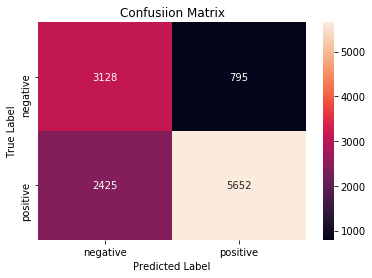

100%|██████████| 1/1 [45:33<00:00, 2733.32s/it]


In [36]:
from time import sleep
from tqdm import tqdm
import multiprocessing as mp


def main122():
    print("started")

    values = range(1)
    with tqdm(total=len(values)) as pbar:
        for i in values:
            pbar.write('processed: %d' %i)
            hyperparam_range=[5,0.1,0.05]

            kernel= ['rbf']
            hp1=dict(kernel=kernel,C=hyperparam_range, gamma=hyperparam_range)
            clf=SVC(class_weight='balanced')
            svm_final =  GridSearchCV(clf,
                                      hp1,
                                    scoring ='roc_auc', 
                                    cv=tscv,
                                    n_jobs= -1)
            svm_final.fit(final_data ,Train_data)
            
            Reg143=svm_final.best_estimator_.get_params()['gamma'] 
            print('Optimal gamma for SVC',Reg143)
            optimal_l143=svm_final.best_estimator_.get_params()['C'] 
            print('Optimal lambada for SVC',(1/optimal_l143))
            prediction_final =svm_final.predict(final_data_test)
            #Training accuracy and training error
            training_score=svm_final.score(final_data,Train_data)
            print('training accuracy=',training_score)
            training_error=1-training_score
            print('training error is =',training_error)
            # Testing Accuracy and testing error 

            Testing_score=round(accuracy_score(y_test_new,prediction_final),5)
            print("Accuracy for SVM model  is = ",Testing_score)
            Testing_error=1-Testing_score
            print("Testing error for SVM model is = ",Testing_error)
            F1_score = round(f1_score(y_test_new ,prediction_final,average='macro'),5)*100
            recall = round(recall_score(y_test_new,prediction_final,average='macro'),5)*100
            precision = round(precision_score(y_test_new,prediction_final,average='macro'),5)*100
            print(classification_report(y_test_new,prediction_final))
            cm = confusion_matrix(y_test_new ,prediction_final)
            label = ['negative', 'positive']
            df_conf = pd.DataFrame(cm, index = label, columns = label)
            sns.heatmap(df_conf, annot = True, fmt = "d")
            plt.title("Confusiion Matrix")
            plt.xlabel("Predicted Label")
            plt.ylabel("True Label")
            plt.show()    
            pbar.update(1)
            sleep(1)

if __name__=='__main__':
    mp.freeze_support()
    main122()
   

# Observations

* Optimal gamma for SVC =  0.05

* Optimal lambada for SVC = 10.0

* training accuracy= 0.8971495409649287

* training error is = 0.10285045903507128

* Accuracy for SVM model  is =  0.73167

* Testing error for SVM model is =  0.26832999999999996

* From confusion metrics, TPR & TNR  is high and FPR & FNR is low. It means model performs is sensible and model works well.

* SVC using BOW with scoring metrics "roc_auc" performs well to classify postive and negative reviews .